# IBI analysis around Raven Matrix feedback time

See this paper for more information about the IBI analysis: https://www.sciencedirect.com/science/article/abs/pii/S0301051118300243 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

from pathlib import Path
from tqdm.auto import tqdm
from IPython.display import display

from speech_study.path_conf import loc_data_dir, report_dir
from speech_study.data_parsing import parse_timeline_file, parse_marker_file

pd.options.display.max_columns = None

In [3]:
# configure user
user = "jonas"

if user.lower() == "jonas":
    BASE_PATH = "/users/jonvdrdo/jonas/data/aaa_contextaware/raw/uz_study/"
elif user.lower() == "mitchel":
    BASE_PATH = "D:/Data/EEG_Study_1/"  # Go check 1_audio_preprocess.py
DATA_PATH = BASE_PATH + "aligned_data"

In [4]:
df_log_sex = pd.read_csv(loc_data_dir.joinpath('sex_mapping.csv'))
df_log_sex.sample(3)

,user,sex
65,66,F
5,6,F
74,75,M


## Data processing 

In [5]:
# Construct `df_feedback`, a dataframe which withholds each feedback-observation
# as a row.

feedback_list = []

for p in tqdm(sorted(Path(DATA_PATH).iterdir())):
    if not p.is_dir():
        continue

    # -------------- edf_aligned ----------------
    timeline_file = p.joinpath("timeline_aligned.csv")
    marker_file = p.joinpath("marker_edf_aligned.csv")
    if timeline_file.exists() and marker_file.exists():
        edf_source = "edf_aligned"

        # 1. if both files exists, read them and parse the time columns
        df_timeline = (
            parse_timeline_file(timeline_file)
            .iloc[:, 1:]
            .drop(columns=["OnsetDelay.1"])
        )

        # 2. filter on the feedback events
        df_feedback = df_timeline[
            df_timeline.Phase.str.lower().str.contains("feedback")
        ].copy()

        df_feedback["user"] = p.name
        df_feedback["sex"] = df_log_sex[df_log_sex.user == int(p.name)]["sex"].values[0]
        df_feedback["edf_source_dir"] = edf_source

        # assert that all the previous phases were example slides
        assert all(df_feedback["prev_Phase"].str.lower().str.contains("slide"))
        feedback_list.append(df_feedback)

        continue

    # ------------------------ marker-aligned ---------------------------
    timeline_file = p.joinpath("timeline.csv")
    marker_file = p.joinpath("marker_edf.csv")
    if timeline_file.exists() and marker_file.exists():
        edf_source = "edf"

        # Read the files and parse the columns
        df_timeline = parse_timeline_file(timeline_file).drop(columns=["OnsetDelay.1"])
        df_marker = parse_marker_file(marker_file)

        # align the timeline file to the marker file
        timeline_feedback_times = (
            df_timeline[df_timeline.Phase.str.lower().str.contains("feedback")]
            .reset_index()
            .t_start
        )
        marker_feedback_times = (
            df_marker[df_marker.action.str.lower().str.contains("feedback")]
            .reset_index()
            .timestamp
        )
        df_timeline[["t_start", "t_stop"]] += (
            marker_feedback_times - timeline_feedback_times
        ).median()

        # 4. filter on the feedback events
        df_feedback = df_timeline[
            df_timeline.Phase.str.lower().str.contains("feedback")
        ].copy()

        df_feedback["user"] = p.name
        df_feedback["sex"] = df_log_sex[df_log_sex.user == int(p.name)]["sex"].values[0]
        df_feedback["edf_source_dir"] = edf_source

        # assert that all the previous phases were example slides
        assert all(df_feedback["prev_Phase"].str.lower().str.contains("slide"))
        feedback_list.append(df_feedback)
        del timeline_feedback_times, marker_feedback_times


# construct the feedback dataframe
df_feedback = pd.concat(feedback_list, axis=0, ignore_index=True)
del feedback_list, df_marker, df_timeline, edf_source, timeline_file, marker_file, p

# omit the files which have a delay larger than max_slide_delay
# NOTE: don't do this, as these are the ones who did not answer in time
# max_slide_delay = pd.Timedelta(seconds=0.1)
# print(sum(df_feedback.delay_slide_feedback > max_slide_delay))
# df_feedback = df_feedback[df_feedback.delay_slide_feedback < max_slide_delay]

# show the data
df_feedback.iloc[:, np.r_[0:4, df_feedback.shape[1] - 6: df_feedback.shape[1]]]

  0%|          | 0/85 [00:00<?, ?it/s]

,Phase,Trial,Block,t_start,answered_in_time,answered_correctly,delay_slide_feedback,user,sex,edf_source_dir
0,Controle1Feedback,1.0,4,2020-02-03 10:16:26.896047+01:00,True,False,0 days 00:00:00.075000,10,F,edf
1,Controle1Feedback,2.0,4,2020-02-03 10:17:00.344047+01:00,True,True,0 days 00:00:00.061000,10,F,edf
2,Controle1Feedback,3.0,4,2020-02-03 10:18:11.555047+01:00,True,True,0 days 00:00:00.062000,10,F,edf
3,Controle1Feedback,4.0,4,2020-02-03 10:18:32.854047+01:00,True,True,0 days 00:00:00.066000,10,F,edf
4,Controle1Feedback,5.0,4,2020-02-03 10:18:58.118047+01:00,True,True,0 days 00:00:00.068000,10,F,edf
...,...,...,...,...,...,...,...,...,...,...
4359,Stress3FeedBack,22.0,5,2020-01-31 14:00:26.135688+01:00,True,True,0 days 00:00:00.061000,9,F,edf
4360,Stress3FeedBack,23.0,5,2020-01-31 14:01:08.049688+01:00,True,False,0 days 00:00:00.067000,9,F,edf
4361,Stress3FeedBack,24.0,5,2020-01-31 14:01:22.564688+01:00,True,True,0 days 00:00:00.071000,9,F,edf
4362,Stress3FeedBack,25.0,5,2020-01-31 14:01:42.496688+01:00,True,True,0 days 00:00:00.060000,9,F,edf


In [6]:
# ------------------- HYPERPARAMS -------------------
left_slice_margin_s = 20    # the left time margin (s) from the start-feedback event
right_slice_margin_s = 20   # the right time marin (s) from the strat-feedback event
min_r_peak_threshold = 0.6  # minimum r-peak agreement threshold to still use the data

time_threshold = 0      # first item exceeding `time_threshold` will be set at IBI pos 0
reference_ibi_pos = -2  # the reference position

# the IBI-pos range
min_ibi_pos_range = -7  # Left boundary (wrt. IBI pos 0) in number of IBI's
max_ibi_pos_range = 8   # Right boundary (wrt. IBI pos 0) in number of IBI's


# ---------------- The algorithm ------------------
# See also: Van der veen et al. 2019 - https://doi.org/10.1016/j.biopsycho.2019.05.007

# ----- 1. Iterate over all the users in the feedback file
slcs = []
for user in tqdm(df_feedback.user.unique()):
    df_f_user = df_feedback[df_feedback.user == user]

    # fetch the correct feedback RR_interval data for that user
    f_path = Path(DATA_PATH).joinpath(user, df_f_user.edf_source_dir.values[0])
    f_path = list(f_path.glob("rr_intervals_*.parquet"))
    if len(f_path) != 1:
        print(f"skipping user {user} f_path size {len(f_path)}")
        continue

    rr_file_user = pd.read_parquet(f_path[0]).set_index("timestamp")

    # Iterate of the corresponding user its feedback moments
    for idx, r in df_f_user.iterrows():
        # Construct the slice for the corresponding feedback moment
        # Note: `r.t_start` is the feedback start time
        t_start = r.t_start - pd.Timedelta(seconds=left_slice_margin_s)
        t_end = r.t_start + pd.Timedelta(seconds=right_slice_margin_s)
        slc = rr_file_user[t_start:t_end].copy().reset_index()
        del t_start, t_end

        # Do not use slices with low R-peak agreement or few detected R-peaks
        if len(slc) < 15 or any(slc["r_peak_agreement"] <= min_r_peak_threshold):
            # print(f'skipping slice user - {r.user} - {r.Phase} - {len(slc)}')
            continue

        # Add a relative time col w.r.t. event and feedback_index which will be used
        # to link the data back to df_feedback
        slc["rel_event_time"] = (slc.timestamp - r.t_start).dt.total_seconds()
        slc["feedback_index"] = idx

        # Determine the int-ibi pos
        slc["IBI_pos"] = slc.index - slc[slc.rel_event_time > time_threshold].index[0]
        slc["RR_delta_ms"] = (
            slc.RR_interval_ms
            - slc[slc.IBI_pos == reference_ibi_pos].RR_interval_ms.values[0]
        ).round()
        slcs.append(slc)


df_slc = pd.concat(slcs, axis=0, ignore_index=True)
del slcs, slc, idx, r, f_path, df_f_user, rr_file_user, user

print("df_slc:")
display(df_slc.sample(3))


# Merge df_feedback with the relevant IBI-pos delta's, which are stored in df_slice,
# into df_tot_merged
r_list = []
for feedback_idx, r in tqdm(list(df_feedback.iterrows())):
    rr_d = (
        df_slc[df_slc["feedback_index"] == feedback_idx]
        .copy()
        .set_index("IBI_pos")
        .sort_index()["RR_delta_ms"]
    ).loc[min_ibi_pos_range:max_ibi_pos_range]
    rr_d.index = "IBI_pos" + rr_d.index.astype("str")

    r_list.append(pd.concat([r, rr_d]).to_frame().T)


df_tot_merged = pd.concat(r_list, axis=0)
del r_list, feedback_idx, r, rr_d

print("df_tot_merged:")
display(df_tot_merged.sample(3))


# save df_tot_merged
df_tot_merged.to_parquet(
    loc_data_dir.joinpath(f"df_tot_merged_ibi_pos_{reference_ibi_pos}.parquet"),
    engine="fastparquet",
)

  0%|          | 0/75 [00:00<?, ?it/s]

skipping user 18 f_path size 0
df_slc:


,timestamp,r_peak_agreement,RR_interval_ms,HRV_ms,rel_event_time,feedback_index,IBI_pos,RR_delta_ms
168027,2020-08-20 14:41:19.929687+02:00,0.9,677.735,-3.905,-7.091922,3894,-11,-16.0
48241,2020-02-19 11:19:55.156249+01:00,1.0,839.843,-48.829,-18.838680,1160,-26,107.0
35906,2020-02-17 10:25:18.345703+01:00,1.0,865.234,3.906,-4.506852,892,-6,139.0


  0%|          | 0/4364 [00:00<?, ?it/s]

df_tot_merged:


,Phase,Trial,Block,t_start,t_stop,Procedure[Block],Running[Block],Procedure[Trial],Running[Trial],OnsetDelay,OnsetTime,ACC,CRESP,RESP,Answer,AlgemeneList,CorrectAnswer,ActionDelay,ActionTime,OnsetToOnsetTime,RT,RTTime,DurationError,OffsetDelay,OffsetTime,FinishTime,Duration,Stress3FeedBack,Cyclus,PercentageGood,StartTrigger,FeedbackTrigger,PercentageBad,Time,TimerValue,prev_Phase,answered_in_time,answered_correctly,delay_slide_feedback,user,sex,edf_source_dir,IBI_pos-7,IBI_pos-6,IBI_pos-5,IBI_pos-4,IBI_pos-3,IBI_pos-2,IBI_pos-1,IBI_pos0,IBI_pos1,IBI_pos2,IBI_pos3,IBI_pos4,IBI_pos5,IBI_pos6,IBI_pos7,IBI_pos8
0,Stress2Feedback,17.0,5,2020-01-31 13:56:35.519688+01:00,NaT,Stress,AlgemeneList,StressProc2,StressBlok2,67,3986569,NaN,6.0,6.0,6,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,71.0,63.0,130.0,53.0,NaN,45000.0,Stress2Slide,True,True,0 days 00:00:00.068000,9,F,edf,52.0,-23.0,5.0,31.0,-10.0,0.0,37.0,36.0,23.0,49.0,-12.0,9.0,27.0,-21.0,17.0,33.0
0,Stress3FeedBack,30.0,5,2020-08-21 15:13:44.672711+02:00,NaT,Stress,AlgemeneList,StressProc3,StressBlok3,61,9471366,NaN,6.0,8.0,6,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,76.0,35.0,102.0,51.0,NaN,100000.0,Stress3Slide,True,False,0 days 00:00:00.061000,78,F,edf_aligned,18.0,12.0,8.0,6.0,4.0,0.0,-0.0,0.0,4.0,6.0,16.0,10.0,-0.0,18.0,21.0,12.0
0,Stress3FeedBack,24.0,5,2020-02-12 13:57:15.958047+01:00,NaT,Stress,AlgemeneList,StressProc3,StressBlok3,71,7545063,NaN,2.0,2.0,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,71.0,27.0,94.0,52.0,NaN,45000.0,Stress3Slide,True,True,0 days 00:00:00.072000,21,M,edf_aligned,-33.0,25.0,-92.0,-16.0,49.0,0.0,8.0,68.0,-23.0,-115.0,-125.0,-154.0,-137.0,-127.0,-156.0,-170.0


## Analyse the relative ibi pos w.r.t feedback time

This subsection aims to analyse what the time-relation is between the IBI pos & the feedback start-time

In [7]:
# create df_tot rel -> withholds the relative time w.r.t. the feedback start-time
# for each ibi pos
r_list = []
for feedback_idx, r in tqdm(list(df_feedback.iterrows())):
    rr_d = (
        df_slc[df_slc["feedback_index"] == feedback_idx]
        .copy()
        .set_index("IBI_pos")
        .sort_index()["rel_event_time"]
    ).loc[min_ibi_pos_range:max_ibi_pos_range]
    rr_d.index = "IBI_pos" + rr_d.index.astype("str")

    r_list.append(pd.concat([r, rr_d]).to_frame().T)
df_tot_rel_time = pd.concat(r_list, axis=0)
del r_list, feedback_idx, r, rr_d

df_tot_rel_time.sample(3)

  0%|          | 0/4364 [00:00<?, ?it/s]

,Phase,Trial,Block,t_start,t_stop,Procedure[Block],Running[Block],Procedure[Trial],Running[Trial],OnsetDelay,OnsetTime,ACC,CRESP,RESP,Answer,AlgemeneList,CorrectAnswer,ActionDelay,ActionTime,OnsetToOnsetTime,RT,RTTime,DurationError,OffsetDelay,OffsetTime,FinishTime,Duration,Stress3FeedBack,Cyclus,PercentageGood,StartTrigger,FeedbackTrigger,PercentageBad,Time,TimerValue,prev_Phase,answered_in_time,answered_correctly,delay_slide_feedback,user,sex,edf_source_dir,IBI_pos-7,IBI_pos-6,IBI_pos-5,IBI_pos-4,IBI_pos-3,IBI_pos-2,IBI_pos-1,IBI_pos0,IBI_pos1,IBI_pos2,IBI_pos3,IBI_pos4,IBI_pos5,IBI_pos6,IBI_pos7,IBI_pos8
0,Controle1Feedback,4.0,4,2020-02-13 13:21:05.140156+01:00,NaT,Controle,AlgemeneList,ControleProc1,ControleBlok1,57,5330769,NaN,7.0,7.0,7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,15.0,82.0,56.0,NaN,20000.0,Controle1Slide,True,True,0 days 00:00:00.058000,23,M,edf_aligned,-3.69875,-3.101094,-2.505391,-1.931172,-1.356953,-0.784688,-0.206563,0.373515,0.9575,1.518047,2.074687,2.611797,3.152812,3.687968,4.240703,4.793437
0,Stress2Feedback,11.0,5,2020-07-02 11:03:01.413016+02:00,NaT,Stress,AlgemeneList,StressProc2,StressBlok2,72,8102057,NaN,4.0,4.0,4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,74.0,2.0,69.0,56.0,NaN,20000.0,Stress2Slide,True,True,0 days 00:00:00.073000,65,F,edf_aligned,-5.186454,-4.416923,-3.705985,-2.955985,-2.176688,-1.360282,-0.50872,0.260812,1.127999,1.961984,2.766671,3.526437,4.350655,5.198312,6.020577,6.842843
0,Controle3Feedback,15.0,4,2020-02-21 10:30:28.730344+01:00,NaT,Controle,AlgemeneList,ControleProc3,ControleBlok3,61,5190430,NaN,6.0,2.0,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,73.0,19.0,86.0,62.0,NaN,20000.0,Controle3Slide,True,False,0 days 00:00:00.062000,36,M,edf_aligned,-6.919797,-5.960813,-4.968625,-3.982297,-3.048703,-2.04675,-0.997922,0.129031,1.088015,2.01575,2.982547,4.01575,4.992312,6.097781,7.220828,8.172


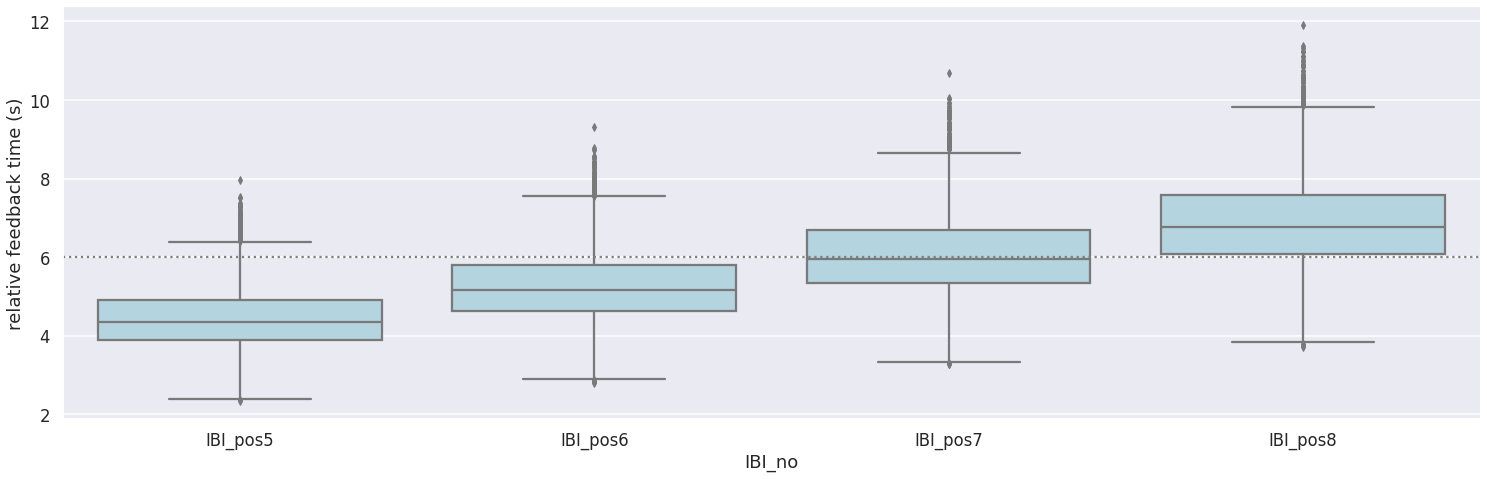

In [8]:
import seaborn as sns

sns.set_context("talk")
sns.set_style("darkgrid")

g = sns.catplot(
    data=df_tot_rel_time.melt(
        value_vars=[f"IBI_pos{i}" for i in np.arange(5, 9)],
        var_name="IBI_no",
        value_name="relative feedback time (s)",
    ),
    x="IBI_no",
    y="relative feedback time (s)",
    kind="box",
    height=7,
    aspect=3,
    color="lightblue",
)

# Note: we add a Hline at t=6s since participants see the feedback for 6 seconds.
g.ax.axhline(y=6, color='grey', linestyle=':')
g.savefig(report_dir.joinpath('ibi_plot.png'))

## IBI Visualizations

In [9]:
# df_tot_merged[df_tot_merged['IBI_pos-7'].isna()].user.value_counts()
low_quality_ecg_users = {18, 55, 80, 13, 11, 15, 35, 77}

### Per trial & group

In [10]:
# visualizing the ibi delta
# if False:
#     fig_list = []
#     for trial in tqdm(sorted(df_feedback.Trial.unique())):
#         shown_groups = []
#         fig = go.Figure()
#         for group in ["Controle", "Stress"]:
#             rr_group = []
#             df_f_gr = df_feedback[
#                 (df_feedback["Procedure[Block]"] == group)
#                 & (df_feedback.Trial == trial)
#             ]
#             for feeback_idx, _ in df_f_gr.iterrows():
#                 rr_d = (
#                     df_slc[df_slc["feedback_index"] == feeback_idx]
#                     .copy()
#                     .set_index("IBI_pos")
#                     .sort_index()["RR_delta_ms"]
#                 )
#                 rr_group.append(rr_d)
#
#             df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False).sort_index()
#             rr_group_mean = df_rr_group.mean(axis=1)
#             rr_group_std = df_rr_group.std(axis=1)
#             fig.add_trace(
#                 go.Scattergl(
#                     x=rr_group_mean.index,
#                     y=rr_group_mean,
#                     error_y=dict(type="data", array=rr_group_std, visible=True),
#                     mode="markers+lines",
#                     name=group + f" n= {df_rr_group.shape[1]}",
#                     legendgroup=group,
#                     showlegend=group not in shown_groups,
#                 )
#             )
#             shown_groups.append(group)
#
#         fig.update_layout(height=400, title=f"feedback - trial {trial}", title_x=0.5)
#         fig.update_xaxes(title_text="Sequential IBI")
#         fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
#         fig.show()
#         fig_list.append(fig)

### Per group & answered-in time

In [ ]:
fig_list = []
fig = go.Figure()
for answer_in_time in [True, False]:
    shown_groups = []
    for group in ["Controle", "Stress"]:
        rr_group = []
        df_f_gr = df_feedback[
            (df_feedback["Procedure[Block]"] == group)
            & (df_feedback.answered_in_time == answer_in_time)
        ]
        for feedback_idx, _ in df_f_gr.iterrows():
            rr_d = (
                df_slc[df_slc["feedback_index"] == feedback_idx]
                .copy()
                .set_index("IBI_pos")
                .sort_index()["RR_delta_ms"]
            )
            rr_group.append(rr_d)

        df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False).sort_index()
        rr_group_mean = df_rr_group.mean(axis=1)
        rr_group_std = df_rr_group.std(axis=1)
        fig.add_trace(
            go.Scattergl(
                x=rr_group_mean.index,
                y=rr_group_mean,
                # error_y=dict(type="data", array=rr_group_std, visible=True),
                mode="markers+lines",
                name=group
                + f"{' NOT' if not answer_in_time else ''} answered in time - n= {df_rr_group.shape[1]}",
                legendgroup=group + str(answer_in_time),
                showlegend=group not in shown_groups,
            )
        )
        shown_groups.append(group)

fig.update_layout(height=400, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) ms")

### Per group & answered correctly

In [ ]:
fig_list = []
fig = go.Figure()
for answered_correctly in [True, False]:
    shown_groups = []
    for group in ["Controle", "Stress"]:
        rr_group = []
        df_f_gr = df_feedback[
            (df_feedback["Procedure[Block]"] == group)
            & (df_feedback.answered_correctly == answered_correctly)
        ]
        for feedback_idx, _ in df_f_gr.iterrows():
            rr_d = (
                df_slc[df_slc["feedback_index"] == feedback_idx]
                .copy()
                .set_index("IBI_pos")
                .sort_index()["RR_delta_ms"]
            )
            rr_group.append(rr_d)

        df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False).sort_index()
        rr_group_mean = df_rr_group.mean(axis=1)
        rr_group_std = df_rr_group.std(axis=1)
        fig.add_trace(
            go.Scattergl(
                x=rr_group_mean.index,
                y=rr_group_mean,
                # error_y=dict(type="data", array=rr_group_std, visible=True),
                mode="markers+lines",
                name=group
                + f"{' NOT' if not answered_correctly else ''} correct - n= {df_rr_group.shape[1]}",
                legendgroup=group + str(answered_correctly),
                showlegend=group not in shown_groups,
            )
        )
        shown_groups.append(group)

fig.update_layout(height=400, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()

In [ ]:
fig = go.Figure()
for sex, group, answered_in_time in [
    ("M", "Controle", True),
    ("M", "Stress", True),
    ("F", "Controle", True),
    ("F", "Stress", True),
]:
    rr_group = []
    df_f_gr = df_feedback[
        (df_feedback["Procedure[Block]"] == group)
        & (df_feedback.sex == sex)
        & (df_feedback.answered_in_time == answered_in_time)
    ]
    for feedback_idx, _ in df_f_gr.iterrows():
        rr_d = (
            df_slc[df_slc["feedback_index"] == feedback_idx]
            .copy()
            .set_index("IBI_pos")
            .sort_index()["RR_delta_ms"]
        )
        rr_group.append(rr_d)

    df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False).sort_index()
    rr_group_mean = df_rr_group.mean(axis=1)
    rr_group_std = df_rr_group.std(axis=1)
    fig.add_trace(
        go.Scattergl(
            x=rr_group_mean.index,
            y=rr_group_mean,
            #                 error_y=dict(type="data", array=rr_group_std, visible=True),
            mode="markers+lines",
            name=sex
            + " - "
            + group
            + "- answered "
            + ("" if answered_in_time else "not")
            + " in time",
            legendgroup=sex,
            showlegend=True,
        )
    )
    shown_groups.append(group)

fig.update_layout(height=400, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()

In [14]:
# [
#     ("M", "Controle", True, 1),
#     ("M", "Controle", True, 2),
#     ("M", "Controle", True, 3),
#     ("M", "Stress", True, 1),
#     ("M", "Stress", True, 2),
#     ("M", "Stress", True, 3),
#     ("F", "Controle", True, 1),
#     ("F", "Controle", True, 2),
#     ("F", "Controle", True, 3),
#     ("F", "Stress", True, 1),
#     ("F", "Stress", True, 2),
#     ("F", "Stress", True, 3),
# ]

### per block & group

In [ ]:
pallette_dict = {
    'Controle': px.colors.sequential.Blues[2:],
    'Stress': px.colors.sequential.Blues[2:],
}

fig = go.Figure()
for group, answered_in_time, level  in [
    ("Controle", True, 1),
    ("Controle", True, 2),
    ("Controle", True, 3),
    ("Stress", True, 1),
    ("Stress", True, 2),
    ("Stress", True, 3),
]:
    rr_group = []
    df_f_gr = df_feedback[
        (df_feedback["Procedure[Block]"] == group)
        & df_feedback.Phase.str.contains(str(level))
        & (df_feedback.answered_in_time == answered_in_time)
    ]
    for feedback_idx, _ in df_f_gr.iterrows():
        rr_d = (
            df_slc[df_slc["feedback_index"] == feedback_idx]
            .copy()
            .set_index("IBI_pos")
            .sort_index()["RR_delta_ms"]
        )
        rr_group.append(rr_d)

    df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False).sort_index()
    rr_group_mean = df_rr_group.mean(axis=1)
    rr_group_std = df_rr_group.std(axis=1)
    fig.add_trace(
        go.Scattergl(
            x=rr_group_mean.index,
            y=rr_group_mean,
            line_color=pallette_dict[group][(level-1)*2],
            # error_y=dict(type="data", array=rr_group_std, visible=True),
            mode="markers+lines",
            line_dash=('dash' if group == 'Controle' else None),
            name=group + " - block:" + str(level)
            + " - answered "
            + ("" if answered_in_time else "not")
            + " in time",
            legendgroup=group,
            showlegend=True,
        )
    )

fig.update_layout(height=600, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()

### Per difficulty & group

In [ ]:
pallette_dict = {
    'Controle': px.colors.sequential.Blues[2:],
    'Stress': px.colors.sequential.Blues[2:],
}

difficulty_mapping = {
    1: 20000.0,
    2: 45000.0,
    3: 100000.0
}

fig = go.Figure()
for group, answered_in_time, difficulty  in [
    ("Controle", True, 1),
    ("Controle", True, 2),
    ("Controle", True, 3),
    ("Stress", True, 1),
    ("Stress", True, 2),
    ("Stress", True, 3),
]:
    rr_group = []
    df_f_gr = df_feedback[
        (df_feedback["Procedure[Block]"] == group)
        & (df_feedback.TimerValue == difficulty_mapping[difficulty])
        & (df_feedback.answered_in_time == answered_in_time)
    ]
    for feedback_idx, _ in df_f_gr.iterrows():
        rr_d = (
            df_slc[df_slc["feedback_index"] == feedback_idx]
            .copy()
            .set_index("IBI_pos")
            .sort_index()["RR_delta_ms"]
        )
        rr_group.append(rr_d)

    df_rr_group = pd.concat(rr_group, axis=1, ignore_index=False).sort_index()
    rr_group_mean = df_rr_group.mean(axis=1)
    rr_group_std = df_rr_group.std(axis=1)
    fig.add_trace(
        go.Scattergl(
            x=rr_group_mean.index,
            y=rr_group_mean,
            line_color=pallette_dict[group][(difficulty-1)*2],
            # error_y=dict(type="data", array=rr_group_std, visible=True),
            mode="markers+lines",
            line_dash=('dash' if group == 'Controle' else None),
            name=group + " - difficulty: " + str(difficulty)
            + " - answered "
            + ("" if answered_in_time else "not")
            + " in time",
            legendgroup=group,
            showlegend=True,
        )
    )

fig.update_layout(height=600, title="feedback", title_x=0.5)
fig.update_xaxes(title_text="Sequential IBI")
fig.update_yaxes(title_text=f"Delta IBI (ref IBI_{reference_ibi_pos}) (ms)")
fig.show()